<div class="header" style="background-image: url('img/touch_modelling_header_s.png');  background-position: right; width: 100%; height: 316px">
</div>

# UPS 2017: Computational Methods for Touch Behaviour Biometrics


In this notebook we learn about modelling user behaviour for behavioural biometrics. In our example, we model touch targeting behaviour on smartphones to cover these aspects:

1. **Analysis**: Use models to reveal patterns of user behaviour and gain a deeper understanding of interactions.
2. **Prediction**: Use models to predict user errors (and correct them). 
3. **Model tuning**: Make appropriate modelling and parameter choices with respect to practical applications.
4. **Uncertainty**: Consider and handle the consequences of modelling on limited data and incomplete information.
5. **Inference**: Apply models infer additional information, in particular user identity.





# Setup

We first import a few packages.

In [1]:
%load_ext autoreload
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML(open('css/notebook.html').read()))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# Touch targeting data

We use touch data collected from two users in a targeting experiment. They had to touch on cross-hairs with their right hand thumb on a smartphone. The figure shows the general setup:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 600px">
<img src="img/touch_offsets_1.png" style="max-width: 400px"/>
Collecting thumb touches in a targeting experiment.
</div>

For the full dataset and study description see these sources:

* Paper: <a href="http://dl.acm.org/citation.cfm?doid=2678025.2701381">Buschek and Alt. 2015. TouchML: A Machine Learning Toolkit for Modelling Spatial Touch Targeting Behaviour</a>
* Paper: <a href="http://dl.acm.org/citation.cfm?doid=2858036.2858165">Buschek et al. 2016. Evaluating the Influence of Targets and Hand Postures on Touch-based Behavioural Biometrics</a>
* Website: <a href="http://www.medien.ifi.lmu.de/touchml/">TouchML library</a>

## Loading the data

Let's load the data and have a look at it. The data comes in a table with five columns:

* **user**: a user id - here we have two users (ids 0 and 1)
* **touch_x**: the x coordinate of the touch location (between 0 and 1)
* **touch_y**: the y coordinate of the touch location (between 0 and 1)
* **target_x**: the x coordinate of the target location (between 0 and 1)
* **target_y**: the y coordinate of the target location (between 0 and 1)

In [2]:
touch_data = pd.read_csv('./data/touches.csv')
touch_data.head()

,user,touch_x,touch_y,target_x,target_y
0,0.0,0.877778,0.916667,0.839506,0.935248
1,0.0,0.596296,0.157095,0.530864,0.136613
2,0.0,0.189815,0.403716,0.160494,0.402825
3,0.0,0.166667,0.826014,0.160494,0.859187
4,0.0,0.039815,0.465653,0.037037,0.478885


Next, we split the data by user and remove the **user** id column, so that we only have the touches and targets per user:

In [3]:
touches_user_1 = touch_data[touch_data.user==0].values[:,1:]
touches_user_2 = touch_data[touch_data.user==1].values[:,1:]

## Plotting the touches

Now let's take a look at these touches.

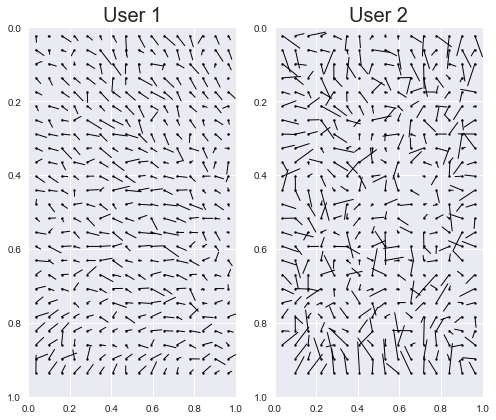

In [4]:
from notebook_code.touch_modelling import plot_touch_data
plot_touch_data(touches_user_1, touches_user_2)

<div class="alert alert-block alert-info"> 
<h1>Discussion: Individual touch behaviour</h1>
<br/>
Compare both users - can you spot differences in their behaviour? How would you describe these differences in your own words?
</div>

# 1. Modelling touch targeting behaviour

Looking at the raw data gives us some insight into user behaviour, but it can be hard to spot what's going on. Thus, let's build a model that captures the underlying **targeting behaviour patterns**. This figure shows the general idea:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 600px">
<img src="img/touch_offsets_2.png"/>
Raw touch errors ("offsets") are fed into a regression model that learns the user's behaviour pattern. 
</div>

To gain an intuitive understanding it is helpful to consider these two views on touch offset models:
1. **Analytic view**: A touch offset model captures a user's touch targeting behaviour. In contrast to raw data, it reveals the underlying behavioural pattern.
2. **Application view**: Given the sensed touch location, a touch offset model predicts where the user really wanted to touch. This can be useful for various applications (e.g. improving touch accuracy by "correcting" touches).

## Touch offset models

A touch offset model allows us to infer where the user really wanted to touch.

Given an observed 2D touch location $t_{observed}=(x, y)$, a touch offset model predicts the offset $o=(\Delta x, \Delta y)$, that is, the distance to the user's intended touch location. Hence, adding this offset to the touch location gives us a prediction for the user's intended touch location: 

$$t_{intended} = t_{observed} + o = (x+\Delta x, y+\Delta y)$$

The figure shows this idea:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 600px">
<img src="img/touch_offset_model.png", style="max-width: 400px"/>
Given a new touch observation, a trained offset model predicts an offset to the target.
</div>

## Modelling touch offsets with Gaussian Processes

The model we use in this notebook is based on **Gaussian Process regression**. Intuitively, you may think of this model as drawing random functions, which map touch locations $(x, y)$ to offsets $(\Delta x, \Delta y)$, from a bag of smooth functions and rejecting those that do not predict well the observed offsets in previously recorded touch data. 

The cell below plots a simplified example of this idea: Say we have made two touch observations from which we want to learn about the user's touch targeting behaviour. For each touch, we have recorded only the $x$-location (to keep this example simple in 1D), and the offset to the target location. To model touch behaviour in this example, we need to find functions that predict the correct offset for each given $x$-location.

Now **run the cell below** - it produces two plots:
1. The left plot shows the **prior**, that is, a bunch of example functions drawn from our bag of smooth functions without considering any observed data.
2. The right plot shows the **posterior**. These are still examples drawn from our bag, but now we only keep those functions that fit our observed data.

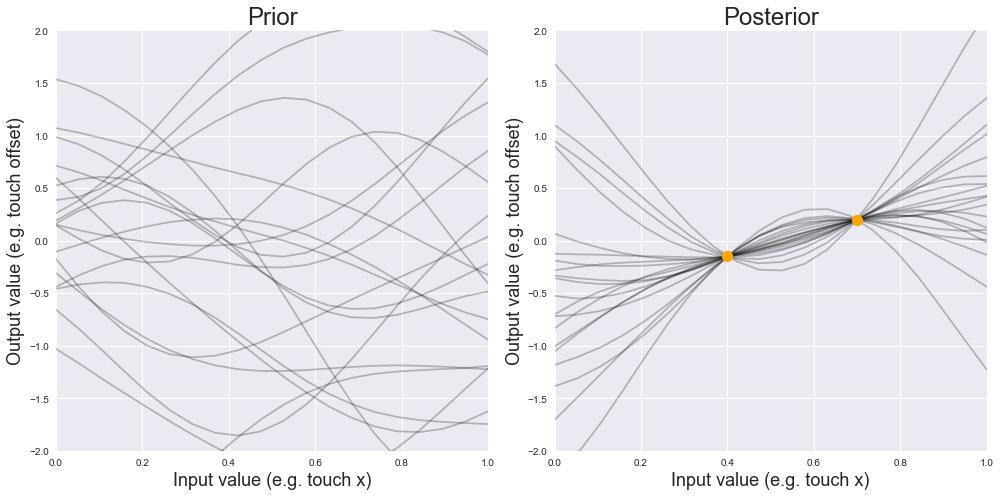

In [5]:
from notebook_code.touch_modelling import plot_gp_example

observations = [
    [0.4, -0.15], # touch 1: x-location, x-offset (distance to target)
    [0.7, 0.2], # touch 2: x-location, x-offset (distance to target)
    # you can add further observations here
]

plot_gp_example(observations) 

<div class="alert alert-block alert-success"> 
<h1>Exercise: Gaussian Process intuition</h1>
<br/>
In the cell above, add further observations, or remove one, or change the existing observations. Then rerun the cell. How does this influence the plots? Based on your observations, can you describe what kind of assumptions or "intuitions" this model implements?
</div>

For more details about Gaussian Processes, in particular for touch interaction, check these sources:
* Paper: <a href="http://dl.acm.org/citation.cfm?id=2380175">Weir et al. 2013. A user-specific machine learning approach for improving touch accuracy on mobile devices</a>
* Paper: <a href="http://dl.acm.org/citation.cfm?doid=2678025.2701381">Buschek and Alt. 2015. TouchML: A Machine Learning Toolkit for Modelling Spatial Touch Targeting Behaviour</a>
* Book: <a href="http://www.gaussianprocess.org/gpml/">Gaussian Processes for Machine Learning</a>
* Video: <a href="https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjM-Kvy2NPUAhXGbRQKHdBaDQYQyCkIKTAA&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3D4vGiHC35j9s&usg=AFQjCNG0wWo7r37RCdV4NA5UG1i8X9RVFw">Lecture on Gaussian Processes</a>

Let's create and train one such offset model for each of our two users:

In [6]:
import touchML.models.GPOffsetModel as gp

model_user_1 = gp.GPOffsetModel()
model_user_1.fit(touches_user_1) # train the model on the data from user 1

model_user_2 = gp.GPOffsetModel()
model_user_2.fit(touches_user_2) # train the model on the data from user 2

## Visualising offset models

To visualise what the models have learned, we can plot their predicted touch offsets at each point on the screen. The arrows point from sensed touch location to predicted intended touch location (i.e. an arrow pointing to the top indicates that the user tends to touch below targets in this area).

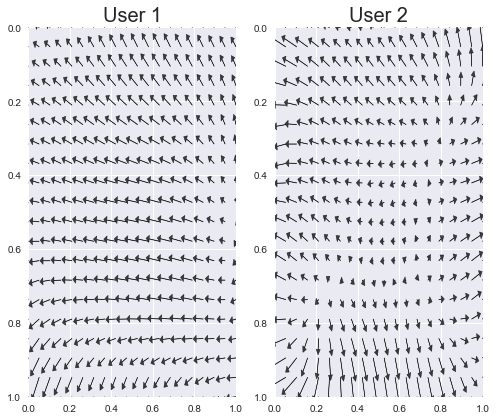

In [7]:
import touchML.visualisation.OffsetModelVis as vis

vis.arrowPlot([model_user_1, model_user_2])

<div class="alert alert-block alert-info"> 
<h1>Discussion: Individual touch behaviour patterns</h1>
<br/>
Compare both users based on their models - it should be easier to spot and describe differences now.
</div>

## Alternative visualisations of offset models

Instead of plotting arrows that point from sensed to intended touch location, we can also plot **contours**. These show the regions of (roughly) similar touch offset lengths. Since we use colour here, not arrows, we can only plot one dimension ($x$ or $y$) at a time. On the upside, the patterns now become more visible.

Let's start by plotting the **horizontal targeting errors** ($x$ offsets): teal indicates "touched too far left", brown means "touched too far right", relative to the targets in the respective areas.

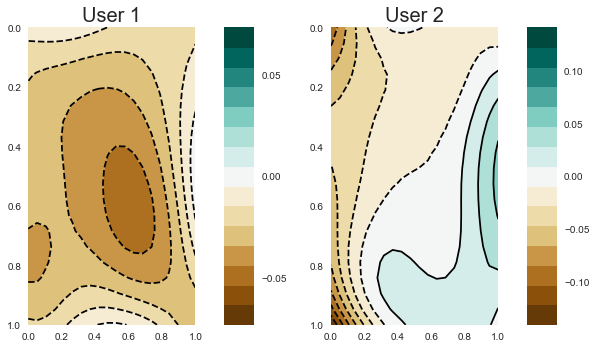

In [8]:
vis.contourPlot([model_user_1, model_user_2], dim='x') # contours for x dimension (i.e. horizontal offsets)

Complementary, we plot **vertical targeting errors** ($y$ offsets): teal indicates "touched too far to the top", brown means "touched too far to the bottom", relative to the targets in the respective areas.

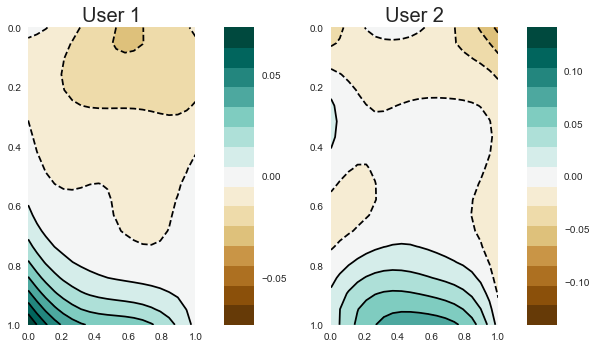

In [9]:
vis.contourPlot([model_user_1, model_user_2], dim='y') # contours for y dimension (i.e. vertical offsets)

# 2. Improving touch accuracy

As a first application of our offset models, we correct the user's future touches to improve touch accuracy. In practice it would work like this: For each new touch, we ask the model where the user really intended to touch and shift the touch location there before passing it on to the operating system, other applications, etc. Remember the figure from before:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 600px">
<img src="img/touch_correction.png"/>
Given a new touch observation, a trained offset model predicts an offset. Shifting the touch location by this offset improves touch accuracy.
</div>

## Loading a test set

Models should never be tested on the same data that was used for training. Hence, we first load a test set: This new data was collected from the same users for the same task (touching cross-hairs with the right thumb on a smartphone), but it was recorded a week after the first data collection.

In [10]:
new_touch_data = pd.read_csv('./data/touches2.csv')
new_touches_user_1 = new_touch_data[new_touch_data.user==0].values[:,1:]
new_touches_user_2 = new_touch_data[new_touch_data.user==1].values[:,1:]

## Measuring touch accuracy improvement

To measure improvement in touch accuracy achieved with the model we compute and compare the root mean squared error (RMSE) for both the raw touches and the touches that we corrected with the model's predictions. The RMSE is defined as:

$$RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}{d_i^2}}$$ 

where $d_i$ is the Euclidean distance between the i-th target location and touch (either raw or corrected). 

In [11]:
from touchML.analysis.OffsetModelAnalysis import computeImprovementInRMSE

improvement_user_1 = computeImprovementInRMSE(new_touches_user_1, model_user_1)
improvement_user_2 = computeImprovementInRMSE(new_touches_user_2, model_user_2)

print 'For user 1, the touch offset model improved touch accuracy by %.2f percent.' % improvement_user_1
print 'For user 2, the touch offset model improved touch accuracy by %.2f percent.' % improvement_user_2

For user 1, the touch offset model improved touch accuracy by 47.55 percent.
For user 2, the touch offset model improved touch accuracy by 15.29 percent.


<div class="alert alert-block alert-success"> 
<h1>Exercise: Applying touch offset models across users</h1>
<br/>
Complete the code in the cell below to investigate what happens if you use the model from user 1 to correct touches from user 2 (and vice versa). 
</div>

In [12]:
improvement_u2_on_u1 = computeImprovementInRMSE(new_touches_user_1, model_user_2)
improvement_u1_on_u2 = computeImprovementInRMSE(new_touches_user_2, model_user_1)

print 'Correcting touches by user 1 with the model from user 2: %.2f percent improvement.' % improvement_u2_on_u1
print 'Correcting touches by user 2 with the model from user 1: %.2f percent improvement.' % improvement_u1_on_u2

Correcting touches by user 1 with the model from user 2: -3.41 percent improvement.
Correcting touches by user 2 with the model from user 1: -10.75 percent improvement.


<div class="alert alert-block alert-info"> 
<h1>Discussion: Improving touch accuracy</h1>
<br/>
Note what works and what doesn't. Which insights into touch targeting behaviour can you gain from these observations?
<br/>
Regarding applications, how might we make the models more robust?
</div>

# 3. Tuning model hyperparameters

Many machine learning models have hyperparameters. In contrast to normal parameters, their values are not learned from the training data. Hyperparameters rather specify properties of the learning algorithm. Thus, hyperparameters often describe a tradeoff between the model's capacity (i.e. ability to learn complex patterns) and its robustness (i.e. ability to generalise well).

Our touch offset model also has several hyperparameters. In the exercise below, we investigate one of them.

<div class="alert alert-block alert-success"> 
<h1>Exercise: Tuning touch offset models</h1>
<br/>
In the cell below, play with the models' **gamma** hyperparameter (default: gamma=2). Answer the following questions:

<ol>
<li>We have not explained gamma yet. From looking at the plots, can you intuitively explain which aspect of the model is controled by gamma?</li>
<li>Can you find a value for gamma that gives a higher improvement than the one we had before?</li>
<li>Do different users need different hyperparameters?</li>
</ol>
</div>

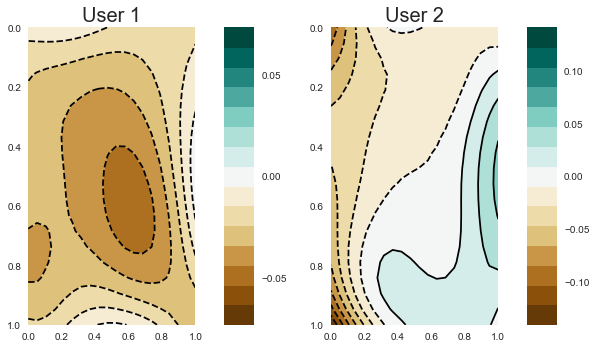

Improvement user 1: 47.55 percent.
Improvement user 2: 15.29 percent.


In [13]:
new_model_user_1 = gp.GPOffsetModel(gamma=2) # TODO: change gamma (default gamma=2)
new_model_user_1.fit(touches_user_1)

new_model_user_2 = gp.GPOffsetModel(gamma=2) # TODO: change gamma (default gamma=2)
new_model_user_2.fit(touches_user_2)

# Visualisation:
vis.contourPlot([new_model_user_1, new_model_user_2], dim='x')

# Print improvements per user:
improvement_user_1 = computeImprovementInRMSE(new_touches_user_1, new_model_user_1)
improvement_user_2 = computeImprovementInRMSE(new_touches_user_2, new_model_user_2)
print 'Improvement user 1: %.2f percent.' % improvement_user_1
print 'Improvement user 2: %.2f percent.' % improvement_user_2

<div class="alert alert-block alert-info"> 
<h1>Discussion: Tuning model hyperparameters</h1>
<br/>
What's your best improvement? Reflect on your tuning process: What would be a more practical approach? Is this approach scientifically valid? 
</div>

# 4. Considering uncertainty in the models' predictions

So far, we have not considered uncertainty in the models' predictions: We just worked with the predicted offsets without quantifying how reliable these predictions are. However, since **no model is perfect**, it is a good idea to keep track of uncertainty in our predictions.

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 800px">
<img src="img/sokrates.png" style="padding-bottom: 1em; max-width: 600px"/>
"All I know is that I know nothing." - Sokrates reminds HCI students to consider uncertain user behaviour.
<br/>
Image from <a href="
https://de.wikipedia.org/wiki/Ich_wei%C3%9F,_dass_ich_nichts_wei%C3%9F#/media/File:David_-_The_Death_of_Socrates.jpg">wikipedia</a>.
</div>

Luckily, our Gaussian Process offset model can already provide uncertainty information. So far, we have only used the predicted offset $o$, which is really just the mean prediction; the model also predicts a covariance matrix $\Sigma$. The model thus gives us a distribution of likely offsets for each touch (see the bag of fitting functions earlier - the model did not give us just one function, but infinitely many variations). For a Gaussian Process this predicted distribution is a normal distribution $\mathcal{N}(o,\Sigma)$, visualised in the figure:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 600px">
<img src="img/touch_prediction_distribution.png" />
For a given touch location, the offset model predicts both a mean offset $\mu$ and a covariance $\Sigma$, which together describe a normal distribution of likely offsets.
</div>

Plotting the log-determinant of $\Sigma$ gives us an idea of the "amount" of uncertainty across the screen (blue is low, red is high): 

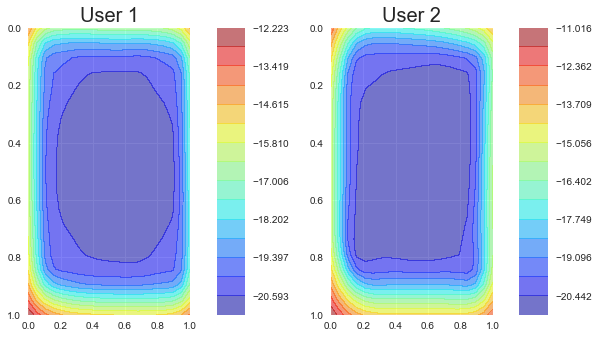

In [14]:
vis.variancePlot([model_user_1, model_user_2])

<div class="alert alert-block alert-info"> 
<h1>Discussion: Uncertainty</h1>
<br/>
Why is uncertainty low in the centre and high near the edges of the screen (for our dataset)?
<br/>
<br/>
**Hint:** You can run the cell below to help you answer this question.
</div>

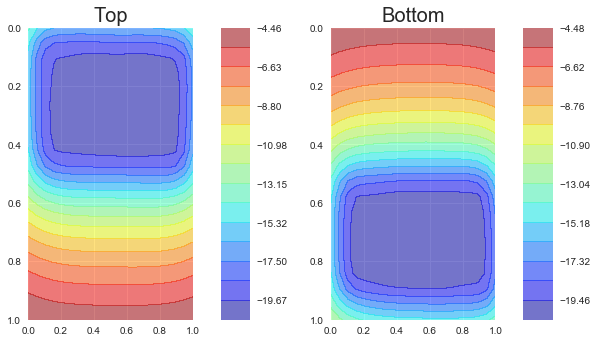

In [15]:
# Train a model only on touches in the top half of the screen:
top_half_touches = touches_user_1[touches_user_1[:,1] < 0.5]
model_top = gp.GPOffsetModel()
model_top.fit(top_half_touches)

# Train a model only on touches in the bottom half of the screen:
bottom_half_touches = touches_user_1[touches_user_1[:,1] > 0.5]
model_bottom = gp.GPOffsetModel()
model_bottom.fit(bottom_half_touches)

vis.variancePlot([model_top, model_bottom], titles=['Top', 'Bottom'])

# 5. Inference based on touch behaviour

Note that, in general, we can think about a user's model as a way of capturing what kind of behaviour we *expect* from that user in the future, basically assuming that people are somewhat consistent. This means that we can use the models to measure how well observed new behaviour matches our expectations. 

Here, we use this approach to infer which user is currently interacting. This is useful, for example, to protect data or personalise a user interface.

## Continuous user identification

This is our approach to inferring which user (from a set of known users) is currently touching - 
for each new touch event:
1. We compute the distribtuion of likely touch location for each user (i.e. our expected behaviour for that user).
2. We update our belief in each user depending on how likely the target is given the predicted distribution (i.e. how well the observation matches our expectation for each user). 

The figure visualises this approach:

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 700px">
<img src="img/touch_classification.png"/>
Recognising users with offset models. We predict a distribution of intended locations with each user’s model to evaluate the true target location. In this example, the target is more likely under the predictive distribution from model B. Hence, we predict that user B is touching.
</div>

### Computing user probabilities 

We evaluate the true target location under a user model's predicted distribution. This likelihood is high if the prediction matches the observed behaviour. We thus interpret it as $p(u|\mathbf{t})$, the likelihood of user $u$ given touch $\mathbf{t}$. We can combine this over multiple touches via multiplication; for a stream of touches $\mathbf{t}_i$, we update our belief that the $k$-th of $N$ users is touching at time $T$:

$$p(u_k) = \frac{\prod\limits_{i=1}^{T} p(u_k|\mathbf{t}_i)}{\sum\limits_{j=1}^{N}\prod\limits_{i=1}^{T} p(u_j|\mathbf{t}_i)}$$


This equation might appear more complex than it is - here's a visual version (for one of two users):

<div class="img_container" style="font-weight: bold; text-align: center; margin: 2em auto; max-width: 500px">
<img src="img/touch_inference_visual_equation.png"/>
</div>

### A common implementation problem: numerical underflow 

Implementing an approach like this one is numerically difficult, since multiplying many $p(u|\mathbf{t}) < 1$ over time results in tiny numerical values that will eventually be cutoff to zero. This problem is typically solved by taking the logarithm - for our equation above:

$$\log{p(u_k)} = \sum\limits_{i=1}^{T} \log p(u_k|\mathbf{t}_i) - \operatorname{logsumexp}_{j=1}^{N}\left(\sum\limits_{i=1}^{T} \log p(u_j|\mathbf{t}_i)\right)$$

where $\operatorname{logsumexp}$ is the "log-sum-exp-trick" for computing the sum of logarithmic terms (for a detailed explanation see this <a href="https://www.youtube.com/watch?v=-RVM21Voo7Q">video</a>).

<div class="alert alert-block alert-success"> 
<h1>Exercise: Continuous user identification</h1>
<br/>
Complete the implementation of the user identification system: Implement the **log_likelihood** function. This implements the idea shown in the figure above: It should return the log-likelihood of the target given the predicted distribution around the corrected touch. 
<br/>
<br/>
You can use the method **multivariate_normal.logpdf(x, mean, covariance)**, which has already been imported from the scipy.stats package. 
</div>

In [16]:
from scipy.stats import multivariate_normal

def log_likelihood(touch, target, predicted_offset, predicted_covariance):
    corrected_touch = touch + predicted_offset
    log_likelihood = multivariate_normal.logpdf(target, corrected_touch, predicted_covariance)
    return log_likelihood

In [26]:
from scipy.misc import logsumexp

def identify_user(model_user_1, model_user_2, new_touches):
    
    predicted_offsets, predicted_covariances = model_user_1.predict(new_touches[:,0:2], returnVar=True)
    predicted_offsets = np.array(predicted_offsets)
    predicted_offsets_2, predicted_covariances_2 = model_user_2.predict(new_touches[:,0:2], returnVar=True)
    predicted_offsets_2 = np.array(predicted_offsets_2)
    history = []
    
    likelihood_user_1 = 0
    likelihood_user_2 = 0
    
    for i in range(len(new_touches)): 
        
        # Get i-th touch and target locations:
        touch = new_touches[i, 0:2]
        target = new_touches[i, 2:4]
                          
        # Compute likelihood by evaluating the target location under each user model's predictive distribution:
        touch_likelihood_user_1 = log_likelihood(touch, target, predicted_offsets[i], predicted_covariances[i])
        touch_likelihood_user_2 = log_likelihood(touch, target, predicted_offsets_2[i], predicted_covariances_2[i])
        
        # Update total likelihoods per user:
        #likelihood_user_1 *= 0.95 # uncomment to better handle the user switch in the final exercise
        #likelihood_user_2 *= 0.95 # uncomment to better handle the user switch in the final exercise
        likelihood_user_1 += touch_likelihood_user_1
        likelihood_user_2 += touch_likelihood_user_2
        
        # Convert to probabilites (this implements the log equation described before):
        likelihood_sum = logsumexp([likelihood_user_1, likelihood_user_2])
        likelihood_ratio_user_1 = likelihood_user_1 - likelihood_sum
        likelihood_ratio_user_2 = likelihood_user_2 - likelihood_sum
        probability_user_1 = np.exp(likelihood_ratio_user_1)
        probability_user_2 = np.exp(likelihood_ratio_user_2)
        
        # Collect history of user probabilities:
        history.append([probability_user_1, probability_user_2])
       
    history = np.array(history)
    return history

Now let's run the identification system:

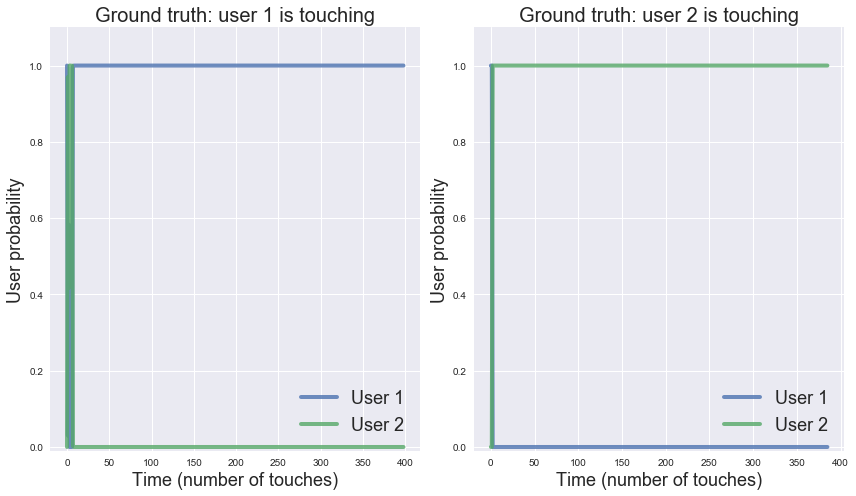

In [29]:
from notebook_code.touch_modelling import plot_user_identification_results

results_u1_touches = identify_user(model_user_1, model_user_2, new_touches_user_1)
results_u2_touches = identify_user(model_user_1, model_user_2, new_touches_user_2)

plot_user_identification_results(results_u1_touches, results_u2_touches)

<div class="alert alert-block alert-info"> 
<h1>Discussion: Continuous user identification</h1>
<br/>
Examine your results: Does the identification work well? When would you rely on the outcome? What else can you observe?
</div>

## Changing users over time

Let's simulate a change in the active user by concatenating touches from both users.

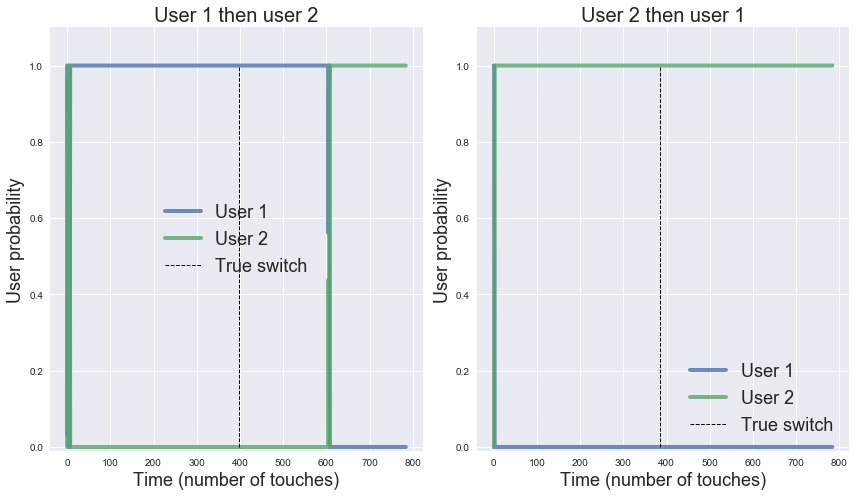

In [30]:
new_touches_u1_then_u2 = np.vstack((new_touches_user_1, new_touches_user_2))
new_touches_u2_then_u1 = np.vstack((new_touches_user_2, new_touches_user_1))

results_u1_then_u2 = identify_user(model_user_1, model_user_2, new_touches_u1_then_u2)
results_u2_then_u1 = identify_user(model_user_1, model_user_2, new_touches_u2_then_u1)

plot_user_identification_results(results_u1_then_u2, results_u2_then_u1, 
                                 titles=['User 1 then user 2', 'User 2 then user 1'],
                                 marks=[len(new_touches_user_1), len(new_touches_user_2)])

<div class="alert alert-block alert-info"> 
<h1>Discussion: Changing users</h1>
<br/>
Examine your results: What is the problem? How could it be improved? 
<br/>
<br/>
**Optional:** Try to achieve a better result by slightly adapting the **identify_user** method.
</div>

# Conclusion

In this notebook we learned about modelling touch targeting behaviour for improving touch accuracy and for inference in behavioural biometrics. We covered these topics:

1. **Analysis**: Comparing offset models for different users revealed their individual targeting behaviour patterns, which were more difficult to perceive when looking at the raw data alone.
2. **Prediction**: We applied the models to correct touches, leading to higher touch accuracy (if the trained model matches the user's behaviour). 
3. **Model tuning**: Finding good hyperparameters improved the models' predictions.
4. **Uncertainty**: Our Gaussian Process model provided not just a single offset prediction, but a whole distribution of likely offsets for each touch. Uncertainty was higher in screen areas where the model had not seen any touches before. It thus appropriately kept track of its lack of information.
5. **Inference**: Finally, we used the models to build a system that can identify which user from a set of known users is currently touching.

<div class="alert alert-block alert-info"> 
<h1>Wrap-up</h1>
<br/>
Reflect on this session. What were the most surprising, challenging, useful or exciting things you learned? What should be changed to improve this session and notebook?
</div>

Feedback or comments? I'd love to hear from you! Get in touch at: daniel.buschek@ifi.lmu.de
